<a href="https://colab.research.google.com/github/elpinchepastel/Indian_Pines/blob/master/Hyperspectral%20Remote%20Sensing%20Scenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hyperspectral Image Reduction**

This project is structured so:

1. Import necessary libraries

2. Download dataset Indian Pines (Correct and gt)

3. Review of dataset structure and loading

4. Visualizing ground truth

5. Visualizing the bands of the Correct

6. Extract pixels and class from the dataset, preparing the data for reduction

7. Dimensionality Reduction (PCA)


## **1. Import necessary libraries**

In [147]:
!pip install tqdm

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.io
import scipy.io as sio
from IPython.display import Image
from scipy.io import loadmat
from sklearn.decomposition import PCA
from tqdm import tqdm

## **2. Download dataset Indian Pines (Correct and gt)**

In [152]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"

--2020-08-14 04:42:23--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat.1’

Indian_pines_correc 100%[===================>]   5.68M   583KB/s    in 12s     

2020-08-14 04:42:35 (499 KB/s) - ‘Indian_pines_corrected.mat.1’ saved [5953527/5953527]

--2020-08-14 04:42:36--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat.1’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-08-14 04:42:36 (212 MB/s) - ‘Indian_pin

In [165]:
# Verify that the ".mat" type dataset is downloaded locally
!ls

drive			    Indian_pines_corrected.mat.1  Indian_pines_gt.mat.1
Indian_pines_corrected.mat  Indian_pines_gt.mat		  sample_data


## **3. Review of dataset structure and loading**

In [166]:
# Data types for the dataset
correct = loadmat('/content/drive/My Drive/ITM/Indian Pines/Indian_pines_gt.mat')
gt = loadmat('/content/drive/My Drive/ITM/Indian Pines/Indian_pines_corrected.mat')
print(type(correct))
print(type(gt))

<class 'dict'>
<class 'dict'>


In [167]:
# The keys of the dictionary
print(f'Dictionary Indian Pines Correct: {correct.keys()}\nDictionary Indian Pines Ground truth: {gt.keys()}')

Dictionary Indian Pines Correct: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
Dictionary Indian Pines Ground truth: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])


In [168]:
# Read the dataset
dataset_correct = scipy.io.loadmat('/content/drive/My Drive/ITM/Indian Pines/Indian_pines_corrected.mat')['indian_pines_corrected']
dataset_gt = scipy.io.loadmat('/content/drive/My Drive/ITM/Indian Pines/Indian_pines_gt.mat')['indian_pines_gt']
print(f'Correct: {dataset_correct.shape}\nGround Truth: {dataset_gt.shape}')

Correct: (145, 145, 200)
Ground Truth: (145, 145)


In [169]:
print(type(dataset_correct))
print(type(dataset_gt))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## **4. Visualizing ground truth**

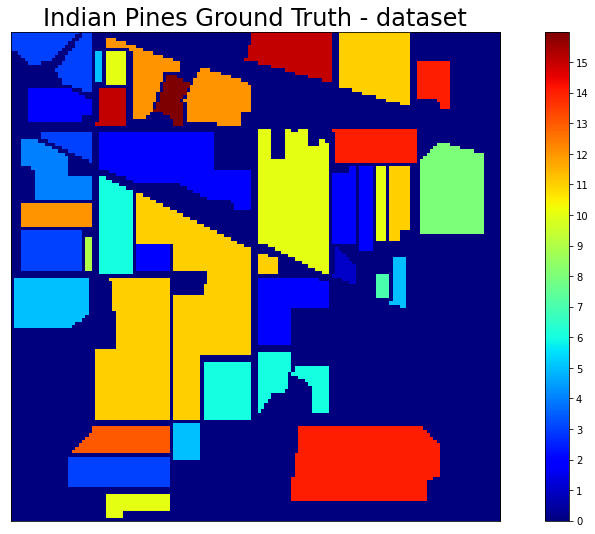

In [170]:
# Display of the "Ground truth" image
plt.figure(figsize=(16, 9))
plt.imshow(dataset_gt, cmap="jet")
plt.title('Indian Pines Ground Truth - dataset', fontsize=24)
plt.colorbar(ticks= range(0,16))
plt.xticks([])
plt.yticks([])
plt.show()

## **5. Visualizing the bands of the Hyperspectral Correct**

Enter the band number of the image you want to view (The number to be between 0 and 199): 
12


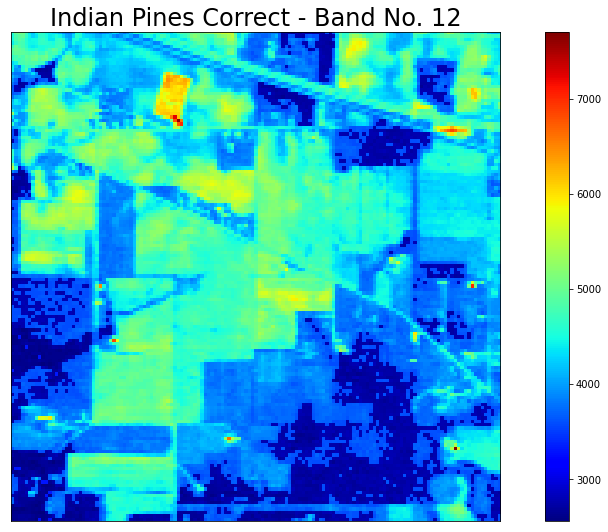

In [171]:
# Display of the "Correct" image on one band
print('Enter the band number of the image you want to view (The number to be between 0 and 199): ')
band = int(input())
one_band = dataset_correct[:, :, band]
plt.figure(figsize=(16, 9))
plt.imshow(one_band, cmap = "jet")
plt.title(f'Indian Pines Correct - Band No. {band}', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

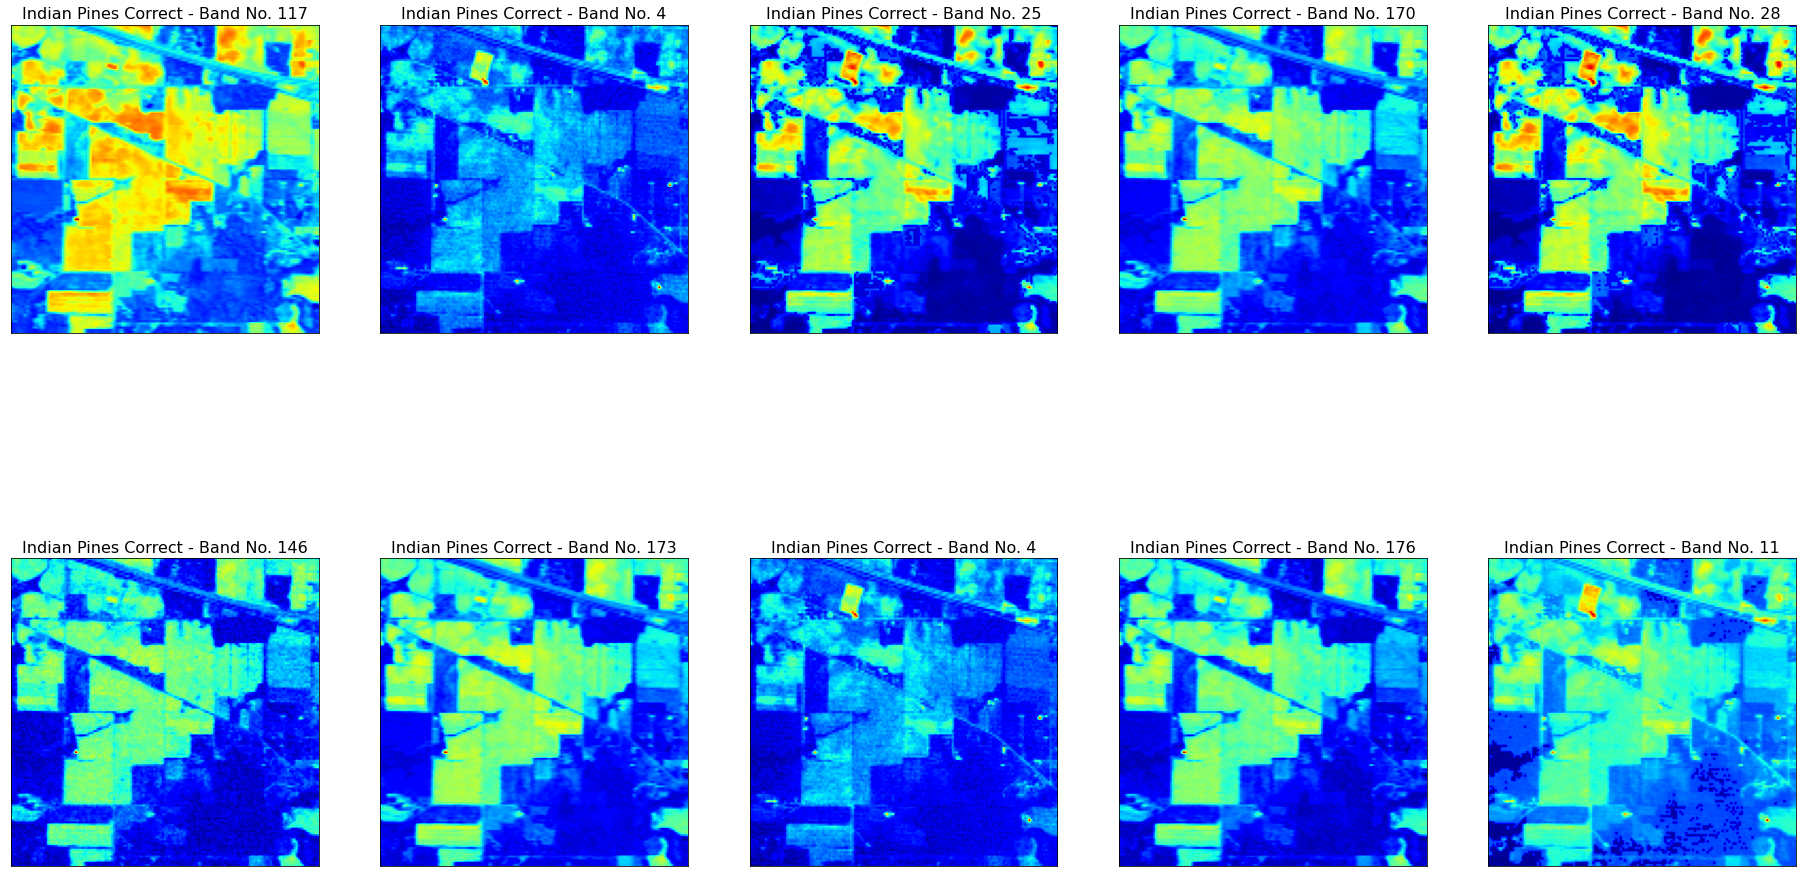

In [172]:
# Display of the "Correct" image on one band random
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    band_aleatory = random.randrange(199)
    one_band = dataset_correct[:, :, band_aleatory]
    plt.imshow(one_band, cmap = "jet")
    plt.title(f'Indian Pines Correct - Band No. {band_aleatory}', fontsize=16)
    plt.xticks([])
    plt.yticks([])
plt.show()

## **6.  Extract pixels and class from the dataset, preparing the data for reduction**

In [187]:
# Extract pixels and class labels from hyperspectral image correct
def extract_pixels(dataset_correct, dataset_gt):
    df = pd.DataFrame()
    for i in tqdm(range(dataset_correct.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset_correct[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(dataset_gt.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset_correct.shape[2])]+['class']
    return df
df = extract_pixels(dataset_correct, dataset_gt)

100%|██████████| 200/200 [00:00<00:00, 394.92it/s]


In [196]:
# Print and save data
df.to_csv('Dataset.csv', index=False)
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [197]:
# Verify the save data locally
!ls

Dataset.csv  Indian_pines_corrected.mat    Indian_pines_gt.mat	  sample_data
drive	     Indian_pines_corrected.mat.1  Indian_pines_gt.mat.1


In [231]:
# Indexation of 145 x 145 of the first two components
dataset_correct = df.iloc[:, :-1].values
dataset_gt = df.iloc[:, -1].values
dataset_correct.shape, dataset_gt.shape
print(f'Size Indian Pines Correct: {dataset_correct.shape}\nSize Indian Pines Ground truth: {dataset_gt.shape}')

Size Indian Pines Correct: (21025, 200)
Size Indian Pines Ground truth: (21025,)


## **7. Dimensionality Reduction (PCA)**

In [234]:
# Implementation of reduction with PCA
print("Enter the band number of the image you want to reduce (the number must be less than 199): ")
n_components = int(input())
pca = PCA(n_components = n_components)
principalComponents = pca.fit_transform(dataset_correct)
print(f"Size Indian Pines Correct Reduced: {principalComponents.shape}")

Enter the band number of the image you want to reduce (the number must be less than 199): 
150
Size Indian Pines Correct Reduced: (21025, 150)


In [237]:
#Reversal of Indexing
dataset_correct_reduced = np.reshape(principalComponents, (145, 145, n_components))
print(f"Size Indian Pines Correct Reduced: {dataset_correct_reduced.shape}")

Size Indian Pines Correct Reduced: (145, 145, 150)


Enter the band number of the image you want to view (The number to be between 0 and 150): 
10


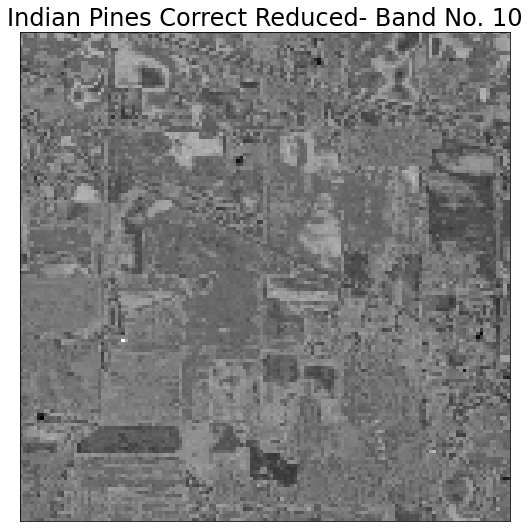

In [238]:
# Display of the "Correct" image on one band
print(f'Enter the band number of the image you want to view (The number to be between 0 and {n_components}): ')
band = int(input())
one_band = dataset_correct_reduced[:, :, band]
plt.figure(figsize=(16, 9))
plt.imshow(one_band, cmap = "gray")
plt.title(f'Indian Pines Correct Reduced- Band No. {band}', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.show()

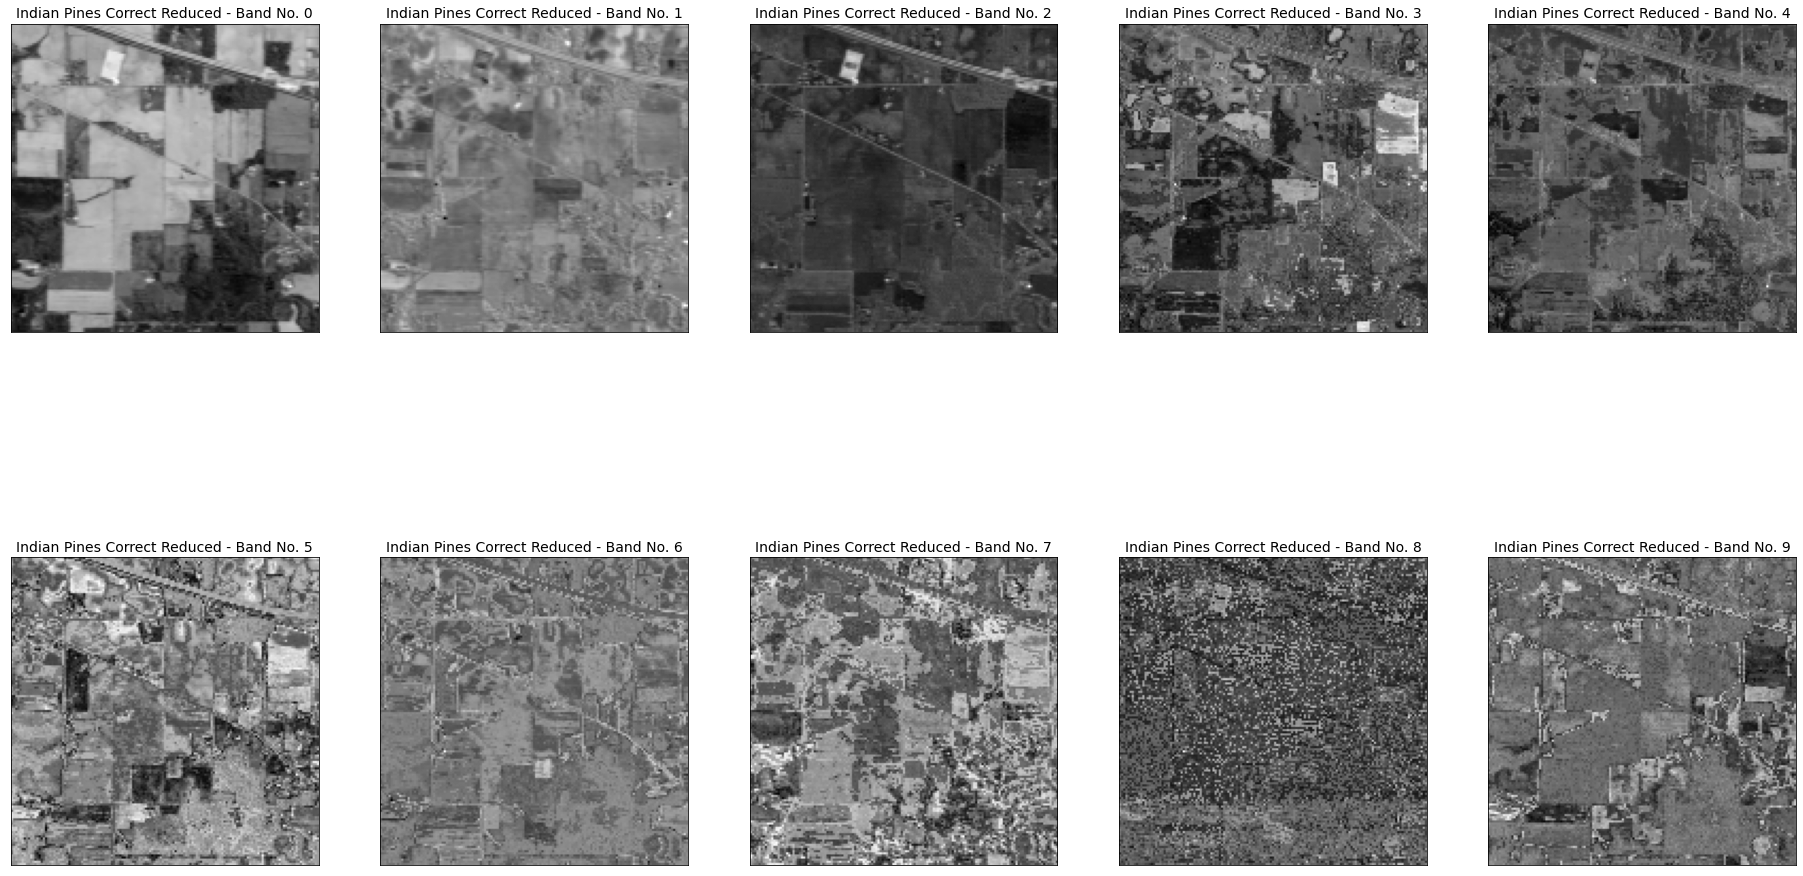

In [239]:
# Displaying the "Reduced Correct" image in the first ten bands
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    I = i-1
    one_band = dataset_correct_reduced[:, :, I]
    plt.imshow(one_band, cmap = "gray")
    plt.title(f'Indian Pines Correct Reduced - Band No. {I}', fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.show()